In [96]:
""" Example to analyze Desroziers uncertainty from file """

import os,sys
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import h5py
from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

""" Test file """
f_conv = '/mnt/users/scratch/leo/scratch/converted_v7/0-20000-0-06610_CEUAS_merged_v1.nc'
f_des = f_conv

STATION = f_conv.split('/')[-1].split('_CEUAS')[0]
station_name = 'Payerne'

station_id = station_name + '('+ STATION + ')'
#F =  h5py.File(f, 'r')

std_plevs    = [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000]

def get_data(file_conv, file_des, variables = [36,38,85,104,105,107], split = False):
    """ Simple script to extract only the most relevant data out of a netCDF file using h5py.
    if split=True, need to read uncertainties from separate desrozier file,
    wile observations data from converted v7 files """
    
    
    f =  h5py.File(file_conv, 'r')
    if split:
        f_des = h5py.File(file_des, 'r')
    else:
        f_des = f 
    dfs = {}
    for v in variables:
        if not os.path.isfile('data/desroziers_dataframe_' + str(v) + '_pickle_' + STATION ):
            print('***** Exctracting Data for Variable: ' , v , ' ***** ')
            res = {}

            indices = f['recordindices'][str(v)]
            imin, imax = min(indices) , max(indices) # I miss here the last entr since I would need the exact index 

            ind_all = np.array([])
            for p in std_plevs:
            #for p in [1000, 2000, ]:
                a = np.where(f['observations_table']['z_coordinate'][imin:imax] == p)[0]
                ind_all = np.append(ind_all, a)


            obs_vars = ['date_time', 'observation_value', 'observed_variable', 'z_coordinate' ]
            fb_vars  = ['biascorr@body' , 'an_depar@body', 'fg_depar@body' ]

            ind_all = list(ind_all)

            print("Reading the observations data ")

            for c in obs_vars:
                res[c] = np.take(f['observations_table'][c][imin:imax], ind_all )

            for c in fb_vars:
                res[c] = np.take(f['era5fb'][c][imin:imax], ind_all )

            print("Reading the uncertainties ")
            unc_vars = f_des['advanced_uncertainty'].keys()
            for c in unc_vars:
                res[c] = np.take(f_des['advanced_uncertainty'][c][imin:imax], ind_all )


            print("--- Creating the data frame ---")
            df = pd.DataFrame.from_dict(res)
            dfs[str(v)] = df
            df.to_pickle('data/desroziers_dataframe_' + str(v) + '_pickle_' + STATION )
        else:
            print('***** Reading variable from pickle: ' , v )
            df = pd.read_pickle('data/desroziers_dataframe_' + str(v) + '_pickle_' + STATION )
            dfs[str(v)] = pd.DataFrame.from_dict(df)

    return dfs

<ipython-input-96-3654f41d830a>:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [97]:
res = get_data(f_conv, f_des, variables = [34,36,38,85,104,105,107], split = True) # dictionary of dataframes 

***** Reading variable from pickle:  34
***** Reading variable from pickle:  36
***** Reading variable from pickle:  38
***** Reading variable from pickle:  85
***** Reading variable from pickle:  104
***** Reading variable from pickle:  105
***** Reading variable from pickle:  107


In [98]:
# Common for all plots 
dic = { 85 : {'x':'Temperature [K]'       , 'y': 'Pressure [hPa]' , 'ylim': (180,340), 'ylimdes': (0,10) } ,
            #106 : {'x': 'Wind from Direction'  , 'y': 'Pressure [hPa]', 'ylim': (180,340), 'ylimdes': (0,14) },
        107 : {'x': 'Wind Speed [m/s] '    , 'y': 'Pressure [hPa]', 'ylim': (0,100), 'ylimdes': (0,30) },
         
        104 : {'x': 'Wind u-component [m/s] '    , 'y': 'Pressure [hPa]', 'ylim': (-50,100), 'ylimdes': (0,30) },
        105 : {'x': 'Wind v-component [m/s] '    , 'y': 'Pressure [hPa]', 'ylim': (-50,100), 'ylimdes': (0,30) },

        34 : {'x': 'Dew Point Depr. [K] '    , 'y': 'Pressure [hPa]', 'ylim': (-5,60), 'ylimdes': (0,30) },
        36 : {'x': 'Dew Point Temp. [K]  '    , 'y': 'Pressure [hPa]', 'ylim': (180,340), 'ylimdes': (0,30) },
        38 : {'x': 'Relative Humidity '       , 'y': 'Pressure [hPa]', 'ylim': (-1.5,1.5), 'ylimdes': (0,1.5) },
        39 : {'x': 'Specific Humidity '      , 'y': 'Pressure [hPa]', 'ylim': (0,0.01), 'ylimdes': (0,0.001) },

          }


In [99]:
def remove_outliers(data= '', min_p= 25, max_p= 75, cut= 1, skewed= False, only_clean = True):
        """ Finds outliers, and replace them with np.nan (to keep vector of same length)                                                                                                                                                                                              

             input ::       data = list of values 
                               min_p , max_p = minimum and maximum values of the percentile to consider to determine outliers 
                               skewed = use True to consider a skewed (not symmetricla Gaussian) distribution 
                               cut = factor to allow slight deviation from given percentiles 
             returns ::   cleaned   = list of values without outliers                                                                                                                                                                    
                               outliers   = list of outlier values                                                                                                                                                                                                               
                               lower,upper, median = outliers delimiter and median values.
            if only_clean == True, return only list of cleaned values. """
        
        q_min, q_max = np.nanpercentile(data, min_p), np.nanpercentile(data, max_p)
        cut_off = (q_max - q_min) * cut
        lower, upper = q_min-cut_off, q_max+cut_off

        if skewed==True:
            q50 = np.nanpercentile(data, 50)
            lower , upper = q_min-(q50-q_min)*cut ,  q_max+(q_max-q50)*cut  # the higher the cut, the more relaxed the contition for exclusion 

        median = np.nanmedian(data)
        cleaned, outliers = [],[]

        indices = []
        for d,ind in zip(np.asarray(data), range(len(data))):
            if d >= lower and d <= upper:
                cleaned.append(d)
                indices.append(ind)
                         
            else: # only storing non nans values 
                if not np.isnan(d):
                    outliers.append(d)

        if only_clean:
            return cleaned, indices
        else:

            return cleaned, indices, outliers, lower, upper, median

In [100]:
def plot_time_series(df_in= '', station='', vars = [] , plev = '', zoom='' ):
    if not os.path.isdir('Plots'):
        os.mkdir('Plots')
    
    if not os.path.isdir('Plots/desroziers'):
        os.mkdir('Plots/desroziers')
        
    import matplotlib.gridspec as gridspec
    text = ''
    fs = 14 # fontsize
    
    STATION = station 
    
    
    for v in vars:
        fig, ax = plt.subplots(figsize=(10,5) )

        df = df_in[str(v)]
        a= df.loc[ df['z_coordinate'] == plev ]
        #print(a.head(n=5))
        x   = a['date_time']
        x = np.array(x)/(3600*24*365.25) + 1900
        obs = a['observation_value']
        y30 = a['desroziers_30']
        y90 = a['desroziers_90']
        y60 = a['desroziers_60']
        y180 = a['desroziers_180']

        #print(y30)
        plt.title('Desroziers Uncertainty for ' + dic[v]['x'] + ' - Station ' + station + ' [' + str(int(plev/100)) + ' hPa]', y = 1.02, fontsize = fs )

        
        #print(OBS[:100], indices[:100])
        
        OBS, indices = remove_outliers(data= a['desroziers_30'], min_p= 25, max_p= 75, cut= 1, skewed= False, only_clean = True)
        X = x[indices]
        plt.plot(X, OBS,  color = 'orange'    , label = 'Des. 30'  )
        
        OBS, indices = remove_outliers(data= a['desroziers_60'], min_p= 25, max_p= 75, cut= 1, skewed= False, only_clean = True)
        X = x[indices]        
        plt.plot(X, OBS,  color = 'lime'      , label = 'Des. 60'  )
        
        OBS, indices = remove_outliers(data= a['desroziers_90'], min_p= 25, max_p= 75, cut= 1, skewed= False, only_clean = True)
        X = x[indices]
        plt.plot(X, OBS,  color = 'slateblue' , label = 'Des. 90'  )        
        
        OBS, indices = remove_outliers(data= a['desroziers_180'], min_p= 25, max_p= 75, cut= 1, skewed= False, only_clean = True)
        X = x[indices]
        plt.plot(X, OBS, color = 'blue'      , label = 'Des. 180' )
        
        plt.ylabel('Uncertainty ', fontsize = fs )
        
        
        
        #ax.set_xlim(1950,2020 ) #todo
        #ax.set_xlim(1900,2020 ) #todo

        if zoom:
            ax.set_xlim(1980,2000 ) #todo
            
        plt.xticks(fontsize=fs)
        plt.yticks(fontsize=fs)

        plt.legend(fontsize = fs)
        plt.grid(color = 'lightgray', ls = ':')
        
        plt.savefig('Plots/desroziers/' + STATION + '_desroziers_series_' + str(v) + '_' + zoom + '.png' , dpi = 150)
        plt.show()
        plt.close()

        
            
            
 

In [101]:
variables = [36, 38, 85,104,105,107]
variables = [36,38, 85, 107]


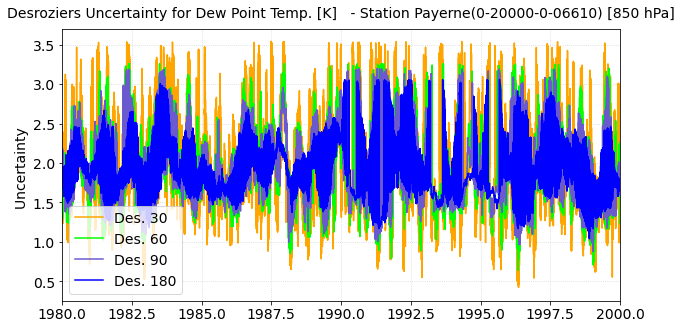

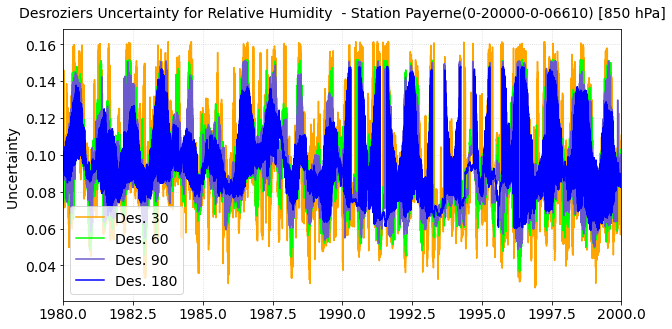

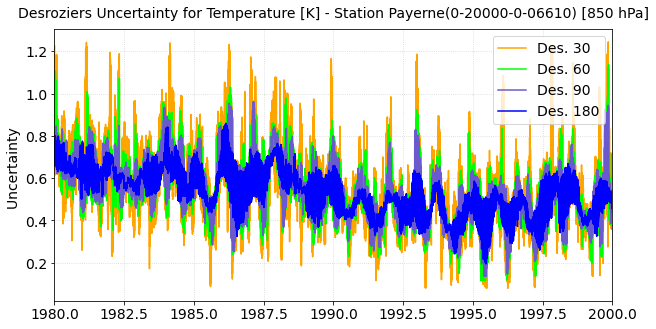

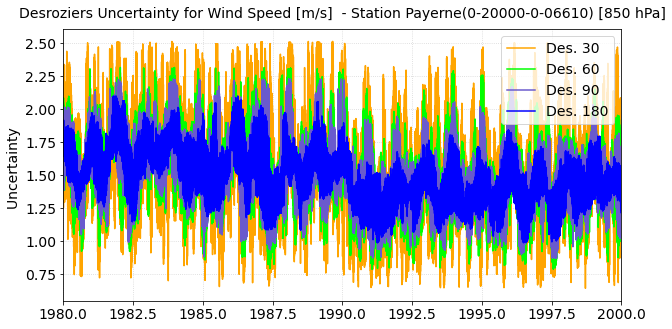

In [102]:
#series = plot_time_series(df_in= res, station=station_id, vars = variables , plev = 85000 )
series = plot_time_series(df_in= res, station=station_id, vars = variables , plev = 85000 , zoom = 'z')

In [103]:
def plot_profile(df_in='', date='', station='', vars = [], zoom = False ):
    
    dic = { 85 : {'x':'Temperature [K]'       , 'y': 'Pressure [hPa]'} ,
            106 : {'x': 'Wind from Direction'  , 'y': 'Pressure [hPa]'},
            107 : {'x': 'Wind Speed [m/s] '    , 'y': 'Pressure [hPa]'},
         
            104 : {'x': 'Wind u-component [m/s] '    , 'y': 'Pressure [hPa]'},
            105 : {'x': 'Wind v-component [m/s] '    , 'y': 'Pressure [hPa]'},

          }
    
    std_plevs    = [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000]
    std_plevs_h = list( np.array(std_plevs) / 100 )

    dt = (date - datetime(1900,1,1,0,0)).total_seconds()

    DATE = date.strftime('%Y%m%d%h%m')


    for v in vars:
        df = df_in[str(v)]
        
        print()
        """ Selecting the variable temperature """
        dt = 3399382800
        #print(df['date_time'][1213000:1213148])
        
        indices = np.where (df['date_time'][:]== dt)[0]
        #print(indices)
        #print(df['date_time'].values[-1])
        df = df.iloc[indices]
        #print(df)
        #print(df[['date_time','desroziers_30','z_coordinate']])
        temp, bias, press, adj = [], [], [], []
        des_30, des_60, des_90, des_180 = [], [], [], []
        des_30_p, des_30_m = [], []
        des_60_p, des_60_m = [], []
        des_90_p, des_90_m = [], []
        des_180_p, des_180_m = [], []

        for p in std_plevs:
            ind = np.where ( df['z_coordinate'] == p )[0]
            DF = df.iloc[ind]
            #print(df)
            if len(ind) > 0:

                t = DF['observation_value'].values[0]
                b = DF['biascorr@body'].values[0]
                d30 = DF['desroziers_30'].values[0]
                d60 = DF['desroziers_60'].values[0]
                d90 = DF['desroziers_90'].values[0]
                d180 = DF['desroziers_180'].values[0]

                if v != 85:
                    b = 0
                    
                if not np.isnan(t) and not np.isnan(b) and not np.isnan(d30):
                    temp.append(t )
                    bias.append(b)
                    des_30.append(d30)
                    des_60.append(d60)
                    des_90.append(d90)
                    des_180.append(d180)
                    
                    press.append(p/100)
                    a = t-b
                    adj.append(a)
                    des_30_m.append(a - d30/2)
                    des_30_p.append(a + d30/2)

                    des_60_m.append(a - d60/2)
                    des_60_p.append(a + d60/2)
                    
                    des_90_m.append(a - d90/2)
                    des_90_p.append(a + d90/2)
                    
                    des_180_m.append(a - d180/2)
                    des_180_p.append(a + d180/2)

        obs_all = df['observation_value'].values
        p_all = df['z_coordinate'].values/100
        
        fs = 20
        fig, ax1= plt.subplots(figsize=(12,10) )        

        fig.suptitle('Station ' + station + ' - Profile '  + DATE , y = 0.94, fontsize = fs)

        ax1.tick_params(axis='both', which='major', labelsize=12)
        ax1.tick_params(axis='both', which='minor', labelsize=8)
        ax1.set_yticks(std_plevs_h)
        w = ax1.invert_yaxis() 

        """ Adding errors band """
        #print(press, des_30_m, des_30_p)
        
     
        
        ax1.errorbar(adj, press , xerr = des_30  , label = 'Desroziers 30'  , color = 'blue' , alpha = 0.4 , lw = 10 , ls = 'none' )
        ax1.errorbar(adj, press , xerr = des_60  , label = 'Desroziers 60'  , color = 'lime' , alpha = 0.4 , lw = 8 , ls = 'none' )
        ax1.errorbar(adj, press , xerr = des_180 , label = 'Desroziers 180' , color = 'red'  , alpha = 0.4 , lw = 6 , ls = 'none' )

        
        ax1.set_ylabel( dic[v]['y'] , fontsize = fs )     
        ax1.set_xlabel( dic[v]['x'] , fontsize = fs )          

        #print(obs_all, p_all)
        #ax1.scatter(obs_all, p_all, color = 'gray' , label = 'All Observations' , s = 15)
        
        ax1.plot(temp, press, color = 'black'   , label = 'Observation'  , lw = 1)     
        ax1.scatter(temp, press, color = 'red'   , label = 'Observation'  , marker = 's' , s = 10)
        ax1.scatter(adj, press, color = 'orange' , label = 'Adjusted Obs.', marker = 's', s = 10)
        
        
        ax1.grid(ls =":" , color = "lightgray")
        ax1.legend(fontsize = fs)
        
        os.system('mkdir Plots')
        
        if v == 85 and zoom:
            ax1.set_xlim (190,250)
            plt.savefig('Plots/desroziers/Desrozier_profile_' + DATE + '_zoom_' + str(v) + '.png', dpi = 150 )
        else:
            plt.savefig('Plots/desroziers/Desrozier_profile_' + DATE + '_' + str(v) + '.png', dpi = 150 )

        plt.show()
        plt.close(9)
    
  

In [110]:
def plot_countour_timeseries(res, var, window, station='', log = True):
    fs = 12
    a = res[str(var)]

    x   = a['date_time']
    x = np.array(x)/(3600*24*365.25) + 1900

    plev = a['z_coordinate']
    num = str(window)
    data = a['desroziers_' + num ]
    finite = np.isfinite(data) # or the interpolation does not like it 

    fig,ax = plt.subplots(figsize = (10,5))
    levels = np.linspace(0,2,50)
    levels = np.linspace(0,0.5,51)

    if var == 85:
        m=3
        levels = np.linspace(0,m,61)
        nums = [0.3*i for i in range(11) ]
        col = 'coolwarm'
        plt.xlim([1970.,2021.])

    elif var == 38 or var == 36:
        m = 0.3
        levels = np.linspace(0,m,31)
        nums = [0.03*i for i in range(11) ]
        col= 'cividis'
        plt.xlim([1970.,2021.])

        
    elif var in [104,105,107]:
        m=5
        levels = np.linspace(0,m,51)
        nums = [0.5*i for i in range(11) ]
        col = 'GnBu_r'
        plt.xlim([1970.,2021.])

    '''
    contours = ax.tricontourf(x[finite], plev[finite]/100, data[finite], levels = levels, cmap = 'viridis', 
                              extend = 'min',
                               vmin = vmin, vmax = vmax)
    '''
    contours = ax.tricontourf(x[finite], plev[finite]/100, data[finite], levels = levels, cmap = col, 
                              extend = 'min')
        
    plt.gca().invert_yaxis()
    log_lab = 'Log'
    if log:
        ax.set_yscale('log')
        plevels_toshow = [10, 20, 30, 50, 70, 100, 150, 300, 500, 700, 850, 1000]

    else:
        log_lab = ''
        plevels_toshow = [10, 50, 70, 100, 150, 300, 500, 700, 850, 925, 1000]


    # [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000]:

    ax.set_yticks( plevels_toshow ) 
    ax.set_yticklabels( plevels_toshow )

    plt.title('Desroziers Uncertainty [' + num + ' days av.]', fontsize = fs, y = 1.03)

    cbar = fig.colorbar(contours)
    

        
    cbar.set_ticks(nums)
    
    #cbar = fig.colorbar(contours )

    cbar.set_label(dic[var]['x'])
    #cbar.ax.set_yticks( list(num_tcks) )
    #cbar.ax.set_yticklabels( list(num_tcks) )
    plt.savefig('Plots/desroziers/Desrozier_contour_error_' + num + '_days_' + str(var) + '_' + log_lab + '.png', dpi = 150 )
        
    plt.show()
    if not os.path.isdir('Plots/desroziers'):
        os.system('mkdir Plots/desroziers/')


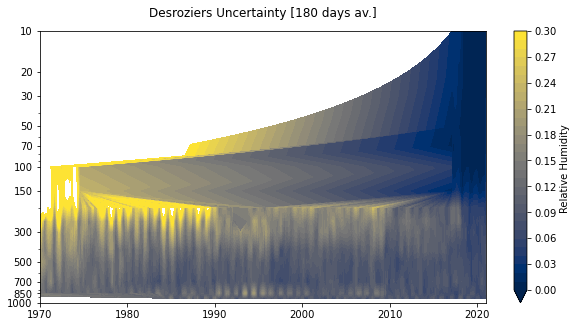

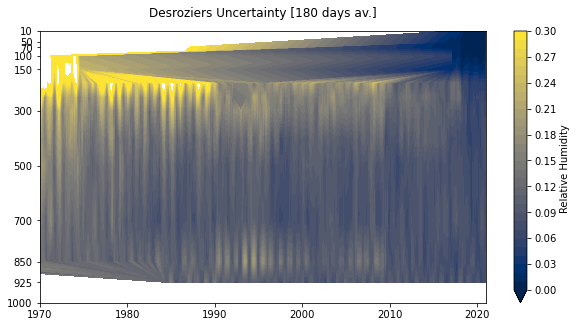

In [108]:
all_level_series= plot_countour_timeseries(res, 38, 180, station=STATION )
all_level_series= plot_countour_timeseries(res, 38, 180, station=STATION , log=False)

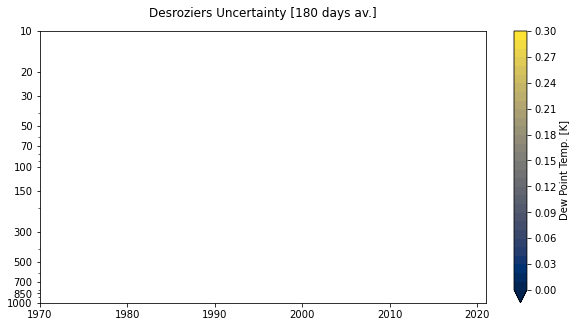

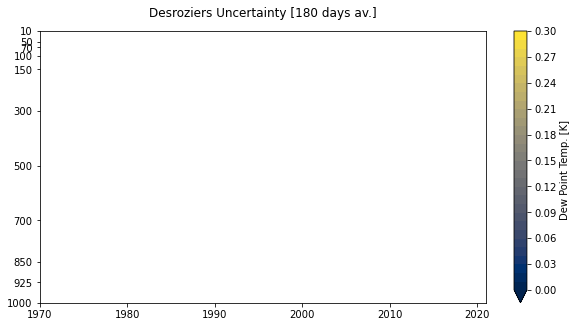

In [111]:
all_level_series= plot_countour_timeseries(res, 36, 180, station=STATION )
all_level_series= plot_countour_timeseries(res, 36, 180, station=STATION , log=False)

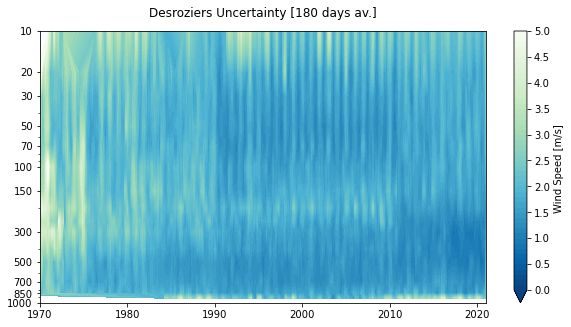

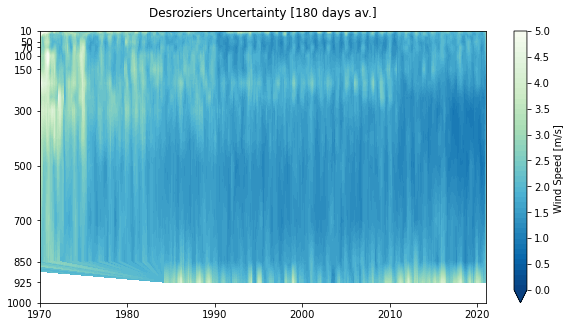

In [112]:
all_level_series= plot_countour_timeseries(res, 107, 180, station=STATION )
all_level_series= plot_countour_timeseries(res, 107, 180, station=STATION , log=False)

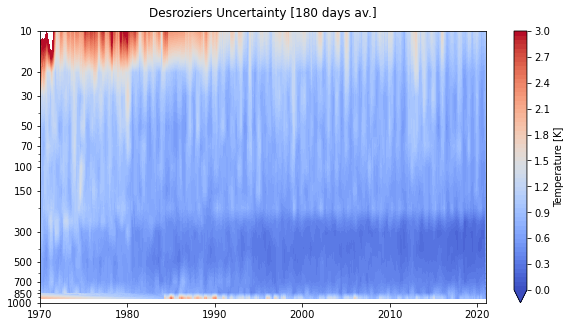

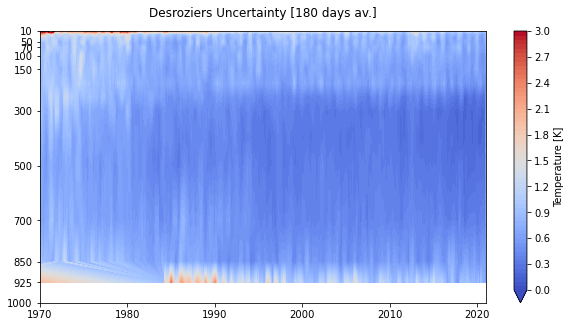

In [113]:
all_level_series= plot_countour_timeseries(res, 85, 180, station=STATION )
all_level_series= plot_countour_timeseries(res, 85, 180, station=STATION , log=False)